In [4]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [5]:
# Imported Interbank FX Rates Historical.csv
Interbank_FX_Rates_Historical = pd.read_csv('./datasets/Interbank FX Rates Historical.csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns GBPGHS
Interbank_FX_Rates_Historical.rename(columns={'Selling': 'GBPGHS'}, inplace=True)

In [6]:
# Imported Interbank FX Rates Historical (1).csv
Interbank_FX_Rates_Historical_1 = pd.read_csv('./datasets/Interbank FX Rates Historical (1).csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical_1.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns USDGHS
Interbank_FX_Rates_Historical_1.rename(columns={'Selling': 'USDGHS'}, inplace=True)

In [7]:
# Merged Interbank_FX_Rates_Historical_1 and Interbank_FX_Rates_Historical into df3
temp_df = Interbank_FX_Rates_Historical.drop_duplicates(subset=['Date']) # Remove duplicates so lookup merge only returns first match
df = Interbank_FX_Rates_Historical_1.merge(temp_df, left_on=['Date'], right_on=['Date'], how='left', suffixes=['_Interbank_FX_Rates_Historical_1', '_Interbank_FX_Rates_Historical'])
df.head()

,Date,USDGHS,GBPGHS
0,31 Dec 2020,7.8787,5.7631
1,30 Dec 2020,7.8087,5.7371
2,29 Dec 2020,7.7383,5.7351
3,24 Dec 2020,7.7779,5.7351
4,23 Dec 2020,7.7344,5.7241


In [8]:
# Check for missing values
print('missing values:', df.isnull().sum().sort_values(ascending = False))

missing values: Date      0
USDGHS    0
GBPGHS    0
dtype: int64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 3225
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3226 non-null   object
 1   USDGHS  3226 non-null   object
 2   GBPGHS  3226 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


In [10]:
df['USDGHS'] = pd.to_numeric(df['USDGHS'], errors='coerce')
df['GBPGHS'] = pd.to_numeric(df['GBPGHS'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Resample the DataFrame to a daily frequency and forward-fill missing values
df = df.resample('D').ffill()
df = df.fillna(method='bfill')
df.describe()

,USDGHS,GBPGHS
count,4748.000000,4748.000000
mean,4.320325,3.040635
std,1.846412,1.547481
min,0.000000,0.000000
25%,2.454700,1.522400
50%,4.878600,3.011850
75%,5.922800,4.404125
max,7.878700,5.763100


In [11]:
df_plot = df.copy()
df.head()

,USDGHS,GBPGHS
Date,,
2008-01-02,1.9427,0.9799
2008-01-03,1.9394,0.9799
2008-01-04,1.9309,0.9798
2008-01-05,1.9309,0.9798
2008-01-06,1.9309,0.9798


<AxesSubplot:xlabel='Date'>

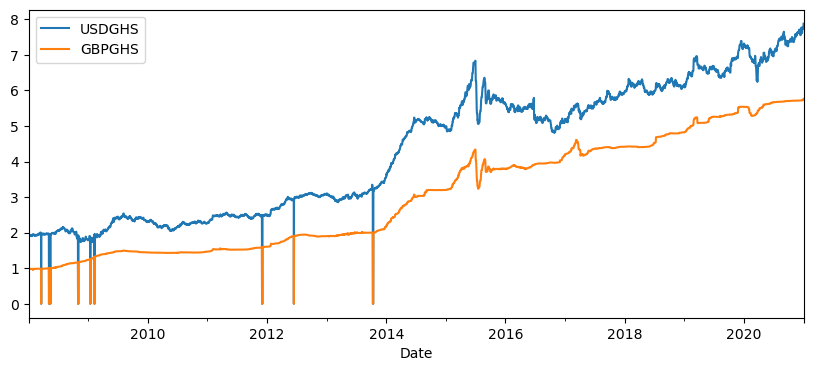

In [12]:
# Let's see a historical view of the closing price
df_plot['USDGHS'].plot(legend=True, figsize=(10,4))
df_plot['GBPGHS'].plot(legend=True, figsize=(10,4))

In [13]:
# Let's go ahead and plot out several moving averages
MA_day = [10,50,200]

for ma in MA_day:
    column_name = 'MA for %s days' %(str(ma))
    df_plot[column_name] = df_plot['USDGHS'].rolling(window=ma).mean()


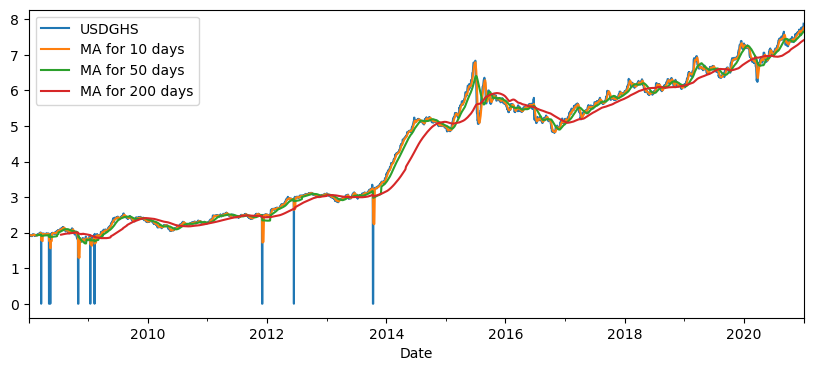

In [14]:
df_plot = df_plot[['USDGHS','MA for 10 days','MA for 50 days','MA for 200 days']].plot(subplots=False,figsize=(10,4))

In [15]:
df = df['USDGHS']
df.isnull().sum()

0

In [16]:
df_diff = df.copy()
# First and second order difference
df_diff = df_diff.diff()
df_diff2 = df_diff.diff(2)


In [17]:
df_diff = df_diff.dropna()
df_diff.head()

Date
2008-01-03   -0.0033
2008-01-04   -0.0085
2008-01-05    0.0000
2008-01-06    0.0000
2008-01-07    0.0034
Freq: D, Name: USDGHS, dtype: float64

In [18]:
df_diff.shape

(4747,)

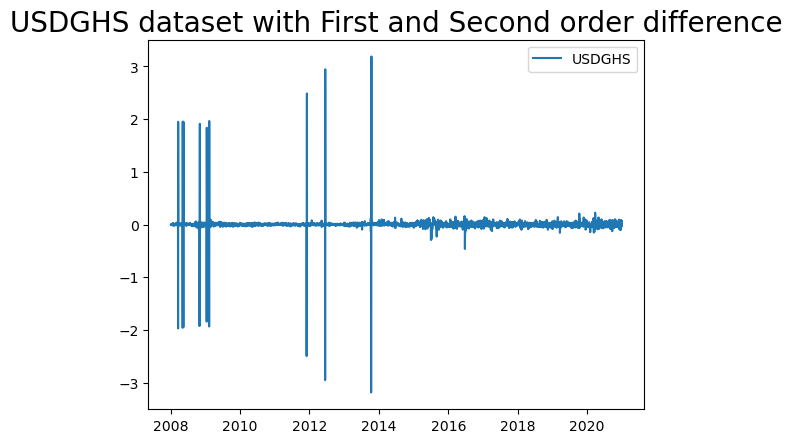

In [19]:

# Plot
plt.title('USDGHS dataset with First and Second order difference', size=20)
plt.plot(df_diff, label='USDGHS')
plt.legend();
plt.show()

It is not necessary to check for autocorrelation in time series before using LSTM. However, it is important to check for autocorrelation in time series data before using any time series model. Autocorrelation is a measure of the correlation between the values of a time series at different points in time. If there is autocorrelation in the data, it means that the values of the time series at one point in time are correlated with the values at other points in time. This can lead to biased estimates of the model parameters and can affect the accuracy of the model predictions

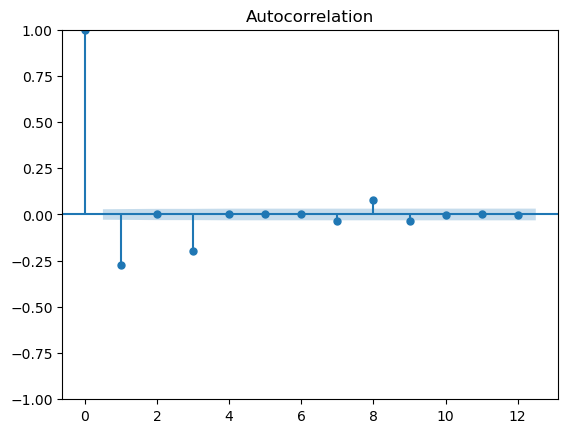

In [20]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(df_diff, lags=12)
plt.show()

In [21]:
# Split the dataset into training, validation, and testing sets
train_df = df_diff.iloc[:int(len(df_diff)*0.6)]
val_df = df_diff.iloc[int(len(df_diff)*0.6):int(len(df_diff)*0.8)]
test_df = df_diff.iloc[int(len(df_diff)*0.8):]

In [22]:
# Define the neural network model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(16, activation='relu'),
    Dense(1)
])

In [23]:

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_df.values, 
                    train_df.values, 
                    validation_data=(val_df.values, val_df.values), 
                    epochs=100, batch_size=32)

Epoch 1/100
89/89 [==============================] - 12s 48ms/step - loss: 0.0116 - val_loss: 1.9103e-04
Epoch 2/100
89/89 [==============================] - 4s 41ms/step - loss: 0.0036 - val_loss: 3.3903e-04
Epoch 3/100
89/89 [==============================] - 3s 29ms/step - loss: 9.2450e-04 - val_loss: 3.2093e-04
Epoch 4/100
89/89 [==============================] - 3s 38ms/step - loss: 3.3622e-04 - val_loss: 3.9129e-04
Epoch 5/100
89/89 [==============================] - 3s 39ms/step - loss: 2.1772e-04 - val_loss: 3.4432e-04
Epoch 6/100
89/89 [==============================] - 5s 54ms/step - loss: 1.8315e-04 - val_loss: 3.0826e-04
Epoch 7/100
89/89 [==============================] - 1s 12ms/step - loss: 1.4201e-04 - val_loss: 2.0163e-04
Epoch 8/100
89/89 [==============================] - 1s 11ms/step - loss: 1.0267e-04 - val_loss: 9.3253e-05
Epoch 9/100
89/89 [==============================] - 1s 15ms/step - loss: 3.4379e-05 - val_loss: 2.4171e-05
Epoch 10/100
89/89 [===============

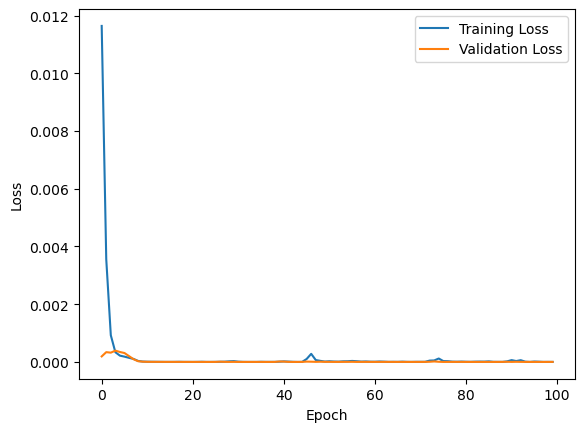

In [24]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:

# Make predictions on the testing data
predictions = model.predict(test_df.values)

30/30 [==============================] - 2s 19ms/step


In [26]:
# Denormalize the predictions and actual values
predictions = predictions 
actual_values = test_df.values

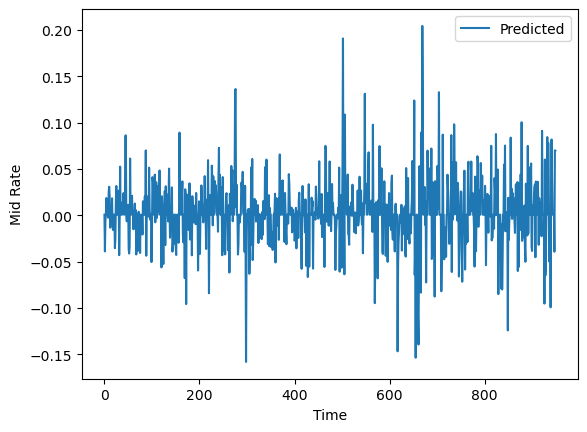

In [27]:
# Plot the predicted and actual values
plt.plot(predictions, label='Predicted')
#plt.plot(actual_values, label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

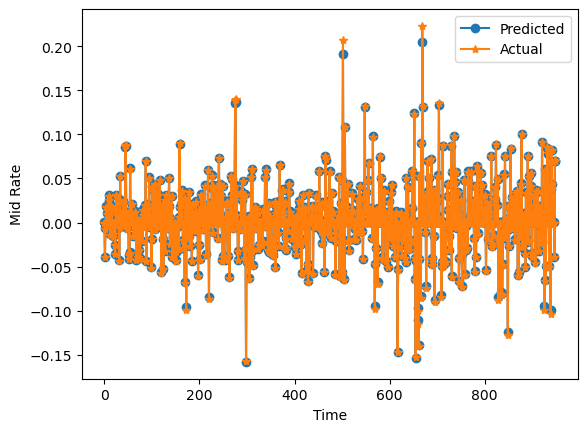

In [28]:
# Plot the predicted and actual values
plt.plot(predictions, marker = 'o' ,label='Predicted')
plt.plot(actual_values,marker = '*', label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

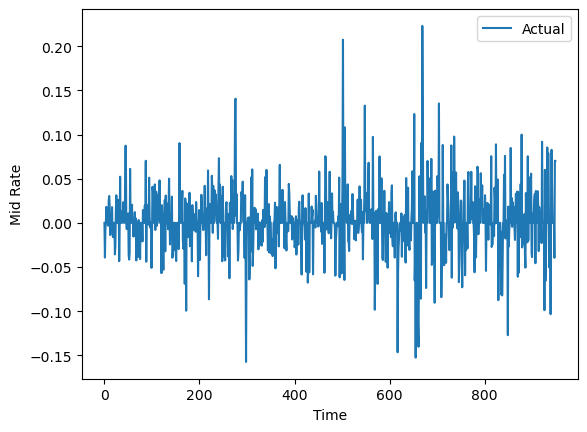

In [29]:
# Plot the predicted and actual values
#plt.plot(predictions, label='Predicted')
plt.plot(actual_values, label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

The RNNs have a feedback mechanism that allows them to take into account the previous inputs in the sequence while making predictions. This feedback loop creates a kind of memory within the network, which is why RNNs are well-suited for sequential data. The mathematical representation of an RNN is:

\begin{equation}
h_t = f(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
\end{equation}

where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, $W_{hh}$ is the weight matrix for the hidden-to-hidden connections, $W_{xh}$ is the weight matrix for the input-to-hidden connections, $b_h$ is the bias term, and $f$ is an activation function.


In [30]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, ConvLSTM2D



LSTM networks are a type of RNN that are designed to address the vanishing gradient problem that can occur in traditional RNNs. LSTM networks use memory cells and gates to selectively remember or forget information from previous inputs. The mathematical representation of an LSTM network is:

\begin{align}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \
\tilde{C}t &= \tanh(W_C \cdot [h{t-1}, x_t] + b_C) \
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \
h_t &= o_t * \tanh(C_t)
\end{align}

where $f_t$ is the forget gate, $i_t$ is the input gate, $o_t$ is the output gate, $\tilde{C}_t$ is the candidate cell state, $C_t$ is the cell state, and $h_t$ is the hidden state. $W_f$, $W_i$, $W_o$, and $W_C$ are the weight matrices, and $b_f$, $b_i$, $b_o$, and $b_C$ are the bias terms. $\sigma$ is the sigmoid activation function, and $\tanh$ is the hyperbolic tangent activation function.

Let's consider a sequence of two-dimensional data, represented as a tensor $X$ of shape $(num_timesteps, height, width, channels)$. At each time step $t$, the input $X[t]$ is processed by a ConvLSTM cell, which consists of several operations.

First, the cell applies a convolution operation to the input $X[t]$ and the previous hidden state $H[t-1]$, with a set of filters $W_x$ and $W_h$, respectively. The output of this convolution is a set of feature maps $F[t]$:

$$F[t] = \text{Conv}(X[t], W_x) + \text{Conv}(H[t-1], W_h)$$

Next, the cell applies several gating mechanisms to control the flow of information through the network. Specifically, it computes three gates: the input gate $i[t]$, the forget gate $f[t]$, and the output gate $o[t]$:

\begin{align*}
i[t] &= \sigma(\text{Conv}(X[t], W_i) + \text{Conv}(H[t-1], U_i)) \
f[t] &= \sigma(\text{Conv}(X[t], W_f) + \text{Conv}(H[t-1], U_f)) \
o[t] &= \sigma(\text{Conv}(X[t], W_o) + \text{Conv}(H[t-1], U_o))
\end{align*}

where $\sigma$ represents the sigmoid activation function, and $W_i$, $W_f$, $W_o$, $U_i$, $U_f$, and $U_o$ are the weights for the convolutional filters used to compute each gate.

These gates control which information is passed through the cell, and which information is discarded. The input gate $i[t]$ determines how much of the new input $F[t]$ is added to the memory cell $C[t]$, which stores the current state of the cell:

$$C[t] = i[t] \cdot \tanh(\text{Conv}(X[t], W_c) + \text{Conv}(H[t-1], U_c)) + f[t] \cdot C[t-1]$$

where $\tanh$ represents the hyperbolic tangent activation function, and $W_c$ and $U_c$ are the weights for the convolutional filters used to compute the cell state.

Finally, the output gate $o[t]$ determines the output of the cell:

$$H[t] = o[t] \cdot \tanh(C[t])$$

where $H[t]$ is the output of the cell at time ste

In [ ]:
# Define RNN model
rnn_model = tf.keras.models.Sequential([
    Input(train_df.shape),
    SimpleRNN(64, activation='relu'),
    Dense(1)
])


ValueError: Input 0 of layer "simple_rnn_3" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2848)

In [ ]:

# Define LSTM model
lstm_model = tf.keras.models.Sequential([
    Input(),
    LSTM(64, activation='relu'),
    Dense(1)
])

# Define ConvLSTM model
convlstm_model = tf.keras.models.Sequential([
    Input(),
    ConvLSTM2D(64, (3,3), activation='relu', padding='same', return_sequences=True),
    ConvLSTM2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    Dense(1)
])

In [ ]:
convlstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the models
rnn_history = rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
convlstm_history = convlstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the models
rnn_score = rnn_model.evaluate(X_test, y_test)
lstm_score = lstm_model.evaluate(X_test, y_test)
convlstm_score = convlstm_model.evaluate(X_test, y_test)

print('RNN Test Score:', rnn_score)
print('LSTM Test Score:', lstm_score)
print('ConvLSTM Test Score:', convlstm_score)